# ИиСМ, Журик Н.С., группа 6, курс 4, ЛР 1

In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from utils import *

Реализуем мультипликативный конгруэнтный генератор. Это по сути простейший генератор псевдослучайных чисел, посмотрим, как он покажет себя на практике.

In [2]:
class UniformDistribution:
    def __init__(self, beta: float = 1203248318,
                 low: float = 0, high: float = 1,
                 seed: int = 1):
        self.a = seed
        self.beta = beta
        self.M = 2 ** 31 - 1
        self.low = low
        self.high = high
        
    def _map_to_range(self, value):
        center = (self.low + self.high) / 2
        diff = (self.high - self.low)
        return diff * (value - 0.5) + center
    
    def mean(self):
        return (self.low + self.high) / 2
        
    def __call__(self, shape: tuple = (1,)):
        n = np.prod(shape)
        random_value = np.empty(n)
        for i in range(n):
            self.a = (self.beta * self.a) % self.M
            random_value[i] = self._map_to_range(self.a / self.M)
        return random_value.reshape(*shape)

Ниже приведён пайплайн для анализа характеристик полученного генератора и сравнения с генератором, реализованным в numpy (из интереса, реализовать свою версию того, чем часто пользуешься, всегда интересно).

In [3]:
def rv_test_pipeline_uniform(dist, np_dist, dist_cdf):
    sampling_sizes = [30, 50, 100, 300, 500, 1000]

    seqs = []
    means = []
    stds = []

    np_seqs = []
    np_means = []
    np_stds = []

    for sampling_size in sampling_sizes:
        generated = dist(shape=(sampling_size,))
        np_seqs.append(np_dist(size=sampling_size))
        seqs.append(generated)
        means.append(seqs[-1].mean())
        stds.append(seqs[-1].std())
        np_means.append(np_seqs[-1].mean())
        np_stds.append(np_seqs[-1].std())
        print(f'Mean for {sampling_size} values: {means[-1]}')
        print(f'Std for {sampling_size} values: {stds[-1]}')

    means = np.array(means)
    stds = np.array(means)
    np_means = np.array(np_means)
    np_stds = np.array(np_stds)
    plot_conv_comparison(sampling_sizes, means, np_means, exact_mean=dist.mean())
    plot_autocov_comparison(seqs[-1], np_seqs[-1])
    plot_scatter_comparison(seqs[3], np_seqs[3])
    plot_hist_comparison(seqs[3], np_seqs[3])
    
    n_bins_chi2 = 5
    EPS = 0.05

    for i in range(len(seqs)):
        seq = seqs[i]
        p_value = find_chi2_p_value(chi2(seq, dist_cdf, k=n_bins_chi2), r=n_bins_chi2-1)
        np_p_value = find_chi2_p_value(chi2(np_seqs[i], dist_cdf, k=n_bins_chi2), r=n_bins_chi2-1)
        print(f'P-value for mcm with {seq.size} elements: {p_value}')
        print(f'P-value for np with {seq.size} elements: {np_p_value}')
        print(f'Null-hypothesis (uniformly distributed) is correct: {p_value > EPS}')
        print()

Mean for 30 values: 0.5037065234673395
Std for 30 values: 0.26920843125236243
Mean for 50 values: 0.44785185111120895
Std for 50 values: 0.26057970065514324
Mean for 100 values: 0.4553969709134647
Std for 100 values: 0.2893658115346463
Mean for 300 values: 0.4732072595118268
Std for 300 values: 0.3021355606716484
Mean for 500 values: 0.5171773821661144
Std for 500 values: 0.28232077518560256
Mean for 1000 values: 0.48482380314861606
Std for 1000 values: 0.2886646912553183


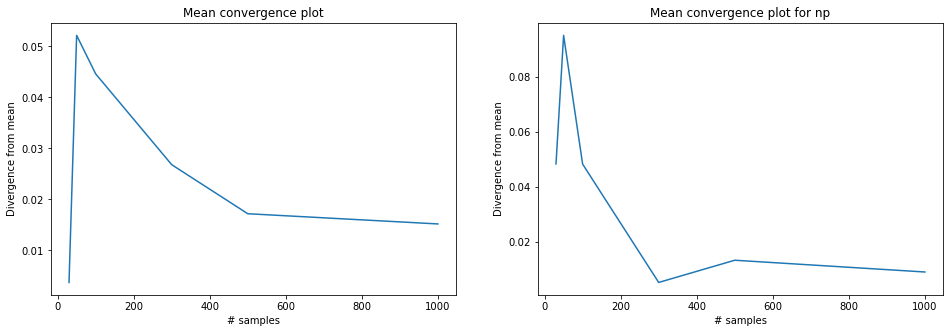

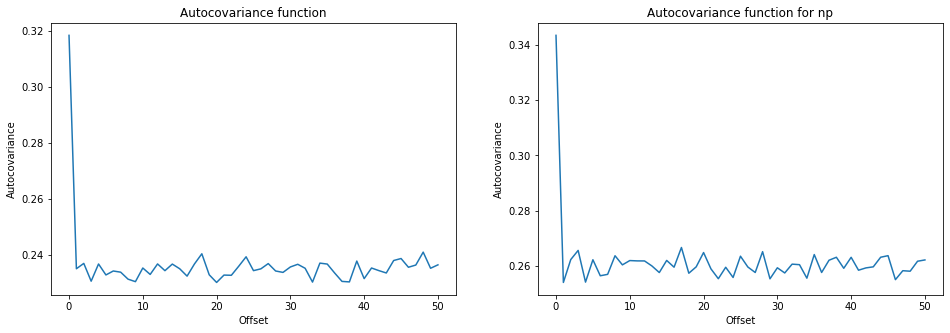

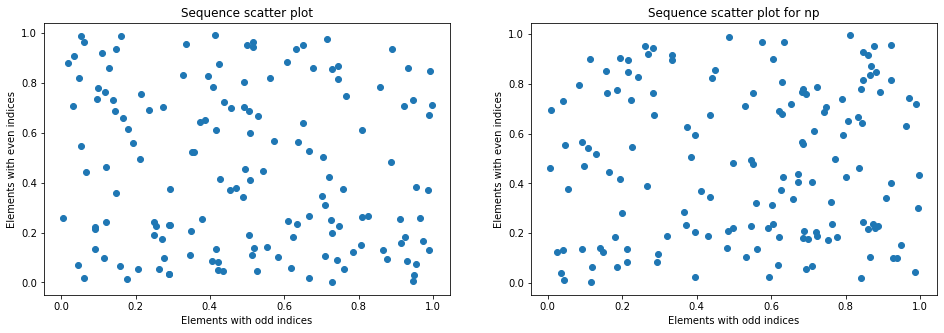

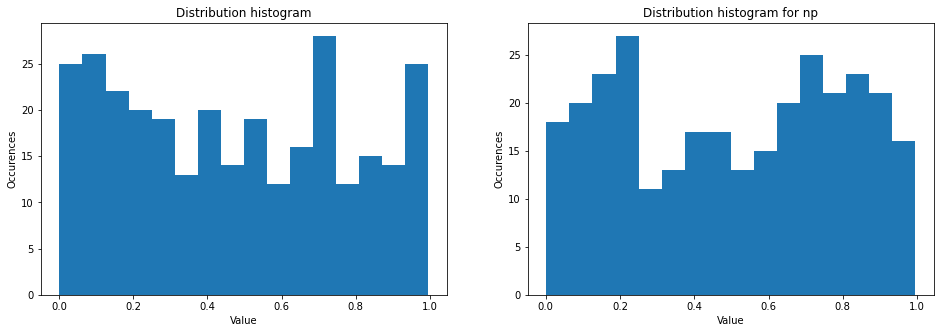

P-value for mcm with 30 elements: 0.9875620123723832
P-value for np with 30 elements: 0.6150599889366957
Null-hypothesis (uniformly distributed) is correct: True

P-value for mcm with 50 elements: 0.184701729813587
P-value for np with 50 elements: 0.11620057441059495
Null-hypothesis (uniformly distributed) is correct: True

P-value for mcm with 100 elements: 0.644635792935428
P-value for np with 100 elements: 0.6092146125178455
Null-hypothesis (uniformly distributed) is correct: True

P-value for mcm with 300 elements: 0.16690280724446493
P-value for np with 300 elements: 0.2641828306082594
Null-hypothesis (uniformly distributed) is correct: True

P-value for mcm with 500 elements: 0.130697110426789
P-value for np with 500 elements: 0.7943473631095075
Null-hypothesis (uniformly distributed) is correct: True

P-value for mcm with 1000 elements: 0.20443726055687828
P-value for np with 1000 elements: 0.5952899780696868
Null-hypothesis (uniformly distributed) is correct: True



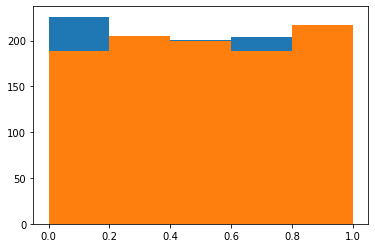

In [4]:
if __name__ == "__main__":
    rv_test_pipeline_uniform(UniformDistribution(), np.random.uniform, lambda x: x)

# Выводы

1. Рассмотренный мультипликативный конгруэнтный генератор позволяет моделировать равномерно распределённую случайную величину, во всех случаях сгенерированная случайная величина удовлетворяет критерию согласия Пирсона, поэтому можем принять нулевую гипотезу - то, что СВ распределена равномерно, - верной.
2. Что касается качества генерации случайной величины, в сравнении с генератором, используемым в np.random, во всех тестах МКМ показывает схожие результаты, отличия не заметны невооружённым глазом. Для более доскональной проверки можно воспользоваться и другими статистическими тестами помимо хи-квадрат.
3. В общем данный генератор показал себя неплохо. Одним из его преимуществ является простота и быстродействие, однако он не является криптостойким.

P.S. Было замечено, что от перезапуска к перезапуску (в зависимости от сида) генераторы иногда производят последовательности с низким p-value (один раз даже было $0.003$).